In [1]:
from math import e

class Node:
    
    

    def __init__(self, x, gradient, hessian, idxs, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
      
        self.x, self.gradient, self.hessian = x, gradient, hessian
        self.idxs = idxs 
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        
        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])
          
        self.score = float('-inf')
        self.find_varsplit()
    def compute_gamma(self, gradient, hessian):
       
        return(-np.sum(gradient)/(np.sum(hessian) + self.lambda_))
    def find_varsplit(self):
       
        for c in self.column_subsample: self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[lhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        self.rhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[rhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        
    def find_greedy_split(self, var_idx):
       
        x = self.x.values[self.idxs, var_idx]
        
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            
            lhs_indices = np.nonzero(x <= x[r])[0]
            rhs_indices = np.nonzero(x > x[r])[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue

            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
    def weighted_qauntile_sketch(self, var_idx):
       
        x = self.x.values[self.idxs, var_idx]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'feature':x,'hess':hessian_})
        
        df.sort_values(by=['feature'], ascending = True, inplace = True)
        hess_sum = df['hess'].sum() 
        df['rank'] = df.apply(lambda x : (1/hess_sum)*sum(df[df['feature'] < x['feature']]['hess']), axis=1)
        
        for row in range(df.shape[0]-1):
            # look at the current rank and the next ran
            rk_sk_j, rk_sk_j_1 = df['rank'].iloc[row:row+2]
            diff = abs(rk_sk_j - rk_sk_j_1)
            if(diff >= self.eps):
                continue
                
            split_value = (df['rank'].iloc[row+1] + df['rank'].iloc[row])/2
            lhs = x <= split_value
            rhs = x > split_value
            
            lhs_indices = np.nonzero(x <= split_value)[0]
            rhs_indices = np.nonzero(x > split_value)[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue
                
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = split_value
                
    def gain(self, lhs, rhs):
        
        gradient = self.gradient[self.idxs]
        hessian  = self.hessian[self.idxs]
        
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian  = hessian[lhs].sum()
        
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian  = hessian[rhs].sum()
        
        gain = 0.5 *( (lhs_gradient**2/(lhs_hessian + self.lambda_)) + (rhs_gradient**2/(rhs_hessian + self.lambda_)) - ((lhs_gradient + rhs_gradient)**2/(lhs_hessian + rhs_hessian + self.lambda_))) - self.gamma
        return(gain)
    @property
    def split_col(self):
        
        return self.x.values[self.idxs , self.var_idx]
                
    @property
    def is_leaf(self):
        
        return self.score == float('-inf') or self.depth <= 0
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        if self.is_leaf:
            return(self.val)

        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

    
class XGBoostTree:
  
    def fit(self, x, gradient, hessian, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
        self.dtree = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight, depth, lambda_, gamma, eps)
        return self
    
    def predict(self, x):
        return self.dtree.predict(X.values)
    

class XGBClassifier:
    
    def __init__(self):
        self.estimators = []
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # first order gradient logLoss
    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds - labels)
    
    # second order gradient logLoss
    def hess(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds * (1 - preds))
    @staticmethod
    def log_odds(column):
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))
    
    
    def fit(self, x, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):

        self.x, self.y = x, y.values
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
    
        self.base_pred = np.full((x.shape[0], 1), 1).flatten().astype('float64')
    
        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.x, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.x)
            self.estimators.append(boosting_tree)
    def predict_proba(self, x):
        pred = np.zeros(x.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(x) 
          
        return(self.sigmoid(np.full((x.shape[0], 1), 1).flatten().astype('float64') + pred))
    
    def predict(self, x):
        pred = np.zeros(x.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(x) 
        
        predicted_probas = self.sigmoid(np.full((x.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return(preds)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

data1=pd.read_csv('/content/drive/MyDrive/Half_Data/ack_h.csv')
data2=pd.read_csv('/content/drive/MyDrive/Half_Data/benign_traffic_h.csv')
data3=pd.read_csv('/content/drive/MyDrive/Half_Data/combo_h.csv')
data4=pd.read_csv('/content/drive/MyDrive/Half_Data/junk_h.csv')
data5=pd.read_csv('/content/drive/MyDrive/Half_Data/scan_h.csv')
data6=pd.read_csv('/content/drive/MyDrive/Half_Data/syn_h.csv')
data7=pd.read_csv('/content/drive/MyDrive/Half_Data/tcp_h.csv')
data8=pd.read_csv('/content/drive/MyDrive/Half_Data/udp_h.csv')
data9=pd.read_csv('/content/drive/MyDrive/Half_Data/udpplain_h.csv')


data1['class']='ack'
data2['class']='benign_traffic'
data3['class']='scan'
data4['class']='junk'
data5['class']='scan'
data6['class']='syn'
data7['class']='tcp'
data8['class']='udp'
data9['class']='udpplain'

data=pd.concat([data1,data2,data3,data4,data5,data6,data7,data8,data9],
               axis=0, sort=False, ignore_index=True)

data.groupby('class')['class'].count()
data

MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  \
0               1.000000      566.000000        0.000000e+00   
1               1.996585      566.000000        5.820000e-11   
2               2.958989      566.000000        0.000000e+00   
3               3.958979      566.000000        0.000000e+00   
4               4.914189      566.000000        1.160000e-10   
...                  ...             ...                 ...   
813555        107.013362      451.270414        4.019486e+04   
813556        108.012301      452.221506        3.991953e+04   
813557        108.716218      453.157691        3.964675e+04   
813558        109.580657      454.077947        3.937690e+04   
813559        109.981077      454.986486        3.910882e+04   

        MI_dir_L3_weight  MI_dir_L3_mean  MI_dir_L3_variance  \
0               1.000000      566.000000        0.000000e+00   
1               1.997950      566.000000        5.820000e-11   
2               2.975291      566.000000        5.820000e-11   
3               3.975285      566.000000        0.000000e+00   
4               4.948239      566.000000        5.820000e-11   
...                  ...             ...                 ...   
813555        177.665918      416.233265        4.907493e+04   
813556        178.664861      417.004355        4.890589e+04   
813557        179.370847      417.768112        4.873728e+04   
813558        180.236616      418.523962        4.856928e+04   
813559        180.644259      419.273922        4.840145e+04   

        MI_dir_L1_weight  MI_dir_L1_mean  MI_dir_L1_variance  \
0               1.000000      566.000000        0.000000e+00   
1               1.999316      566.000000        0.000000e+00   
2               2.991729      566.000000        5.820000e-11   
3               3.991727      566.000000        1.160000e-10   
4               4.982654      566.000000        5.820000e-11   
...                  ...             ...                 ...   
813555        503.050021      389.699401        5.415282e+04   
813556        504.049023      390.025362        5.409883e+04   
813557        504.772381      390.350211        5.404482e+04   
813558        505.646435      390.673856        5.399079e+04   
813559        506.091883      390.996576        5.393672e+04   

        MI_dir_L0.1_weight  ...  HpHp_L0.1_covariance  HpHp_L0.1_pcc  \
0                 1.000000  ...                   0.0            0.0   
1                 1.999932  ...                   0.0            0.0   
2                 2.999171  ...                   0.0            0.0   
3                 3.999171  ...                   0.0            0.0   
4                 4.998261  ...                   0.0            0.0   
...                    ...  ...                   ...            ...   
813555         5226.131516  ...                   0.0            0.0   
813556         5227.130480  ...                   0.0            0.0   
813557         5227.843523  ...                   0.0            0.0   
813558         5228.713068  ...                   0.0            0.0   
813559         5229.139342  ...                   0.0            0.0   

        HpHp_L0.01_weight  HpHp_L0.01_mean  HpHp_L0.01_std  \
0                 1.00000            566.0        0.000000   
1                 1.00000            566.0        0.000000   
2                 1.00000            566.0        0.000000   
3                 1.00000            566.0        0.000000   
4                 1.00000            566.0        0.000000   
...                   ...              ...             ...   
813555        29900.27806            554.0        0.000062   
813556        29901.27747            554.0        0.000062   
813557        29902.11331            554.0        0.000062   
813558        29903.03870            554.0        0.000062   
813559        29903.71057            554.0        0.000062   

        HpHp_L0.01_magnitude  HpHp_L0.01_radius  HpHp_L0.01_covariance  \
0                

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["class"]= le.fit_transform(data["class"])
from sklearn.model_selection import train_test_split

In [5]:
target = "class"

y = data[target]

x = data.drop(target,axis = 1)

In [6]:
x.shape

(813560, 115)

In [7]:
x.head()

MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000           566.0        0.000000e+00          1.000000   
1          1.996585           566.0        5.820000e-11          1.997950   
2          2.958989           566.0        0.000000e+00          2.975291   
3          3.958979           566.0        0.000000e+00          3.975285   
4          4.914189           566.0        1.160000e-10          4.948239   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0           566.0        0.000000e+00          1.000000           566.0   
1           566.0        5.820000e-11          1.999316           566.0   
2           566.0        5.820000e-11          2.991729           566.0   
3           566.0        0.000000e+00          3.991727           566.0   
4           566.0        5.820000e-11          4.982654           566.0   

   MI_dir_L1_variance  MI_dir_L0.1_weight  ...  HpHp_L0.1_radius  \
0        0.000000e+00            1.000000  ...               0.0   
1        0.000000e+00            1.999932  ...               0.0   
2        5.820000e-11            2.999171  ...               0.0   
3        1.160000e-10            3.999171  ...               0.0   
4        5.820000e-11            4.998261  ...               0.0   

   HpHp_L0.1_covariance  HpHp_L0.1_pcc  HpHp_L0.01_weight  HpHp_L0.01_mean  \
0                   0.0            0.0                1.0            566.0   
1                   0.0            0.0                1.0            566.0   
2                   0.0            0.0                1.0            566.0   
3                   0.0            0.0                1.0            566.0   
4                   0.0            0.0                1.0            566.0   

   HpHp_L0.01_std  HpHp_L0.01_magnitude  HpHp_L0.01_radius  \
0             0.0                 566.0                0.0   
1             0.0                 566.0                0.0   
2             0.0                 566.0                0.0   
3             0.0                 566.0                0.0   
4             0.0                 566.0                0.0   

   HpHp_L0.01_covariance  HpHp_L0.01_pcc  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0  

[5 rows x 115 columns]

Remove correlated features

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [9]:
x_train.shape, x_test.shape

((569492, 115), (244068, 115))

check the pearson correaltion on "X_train" data only

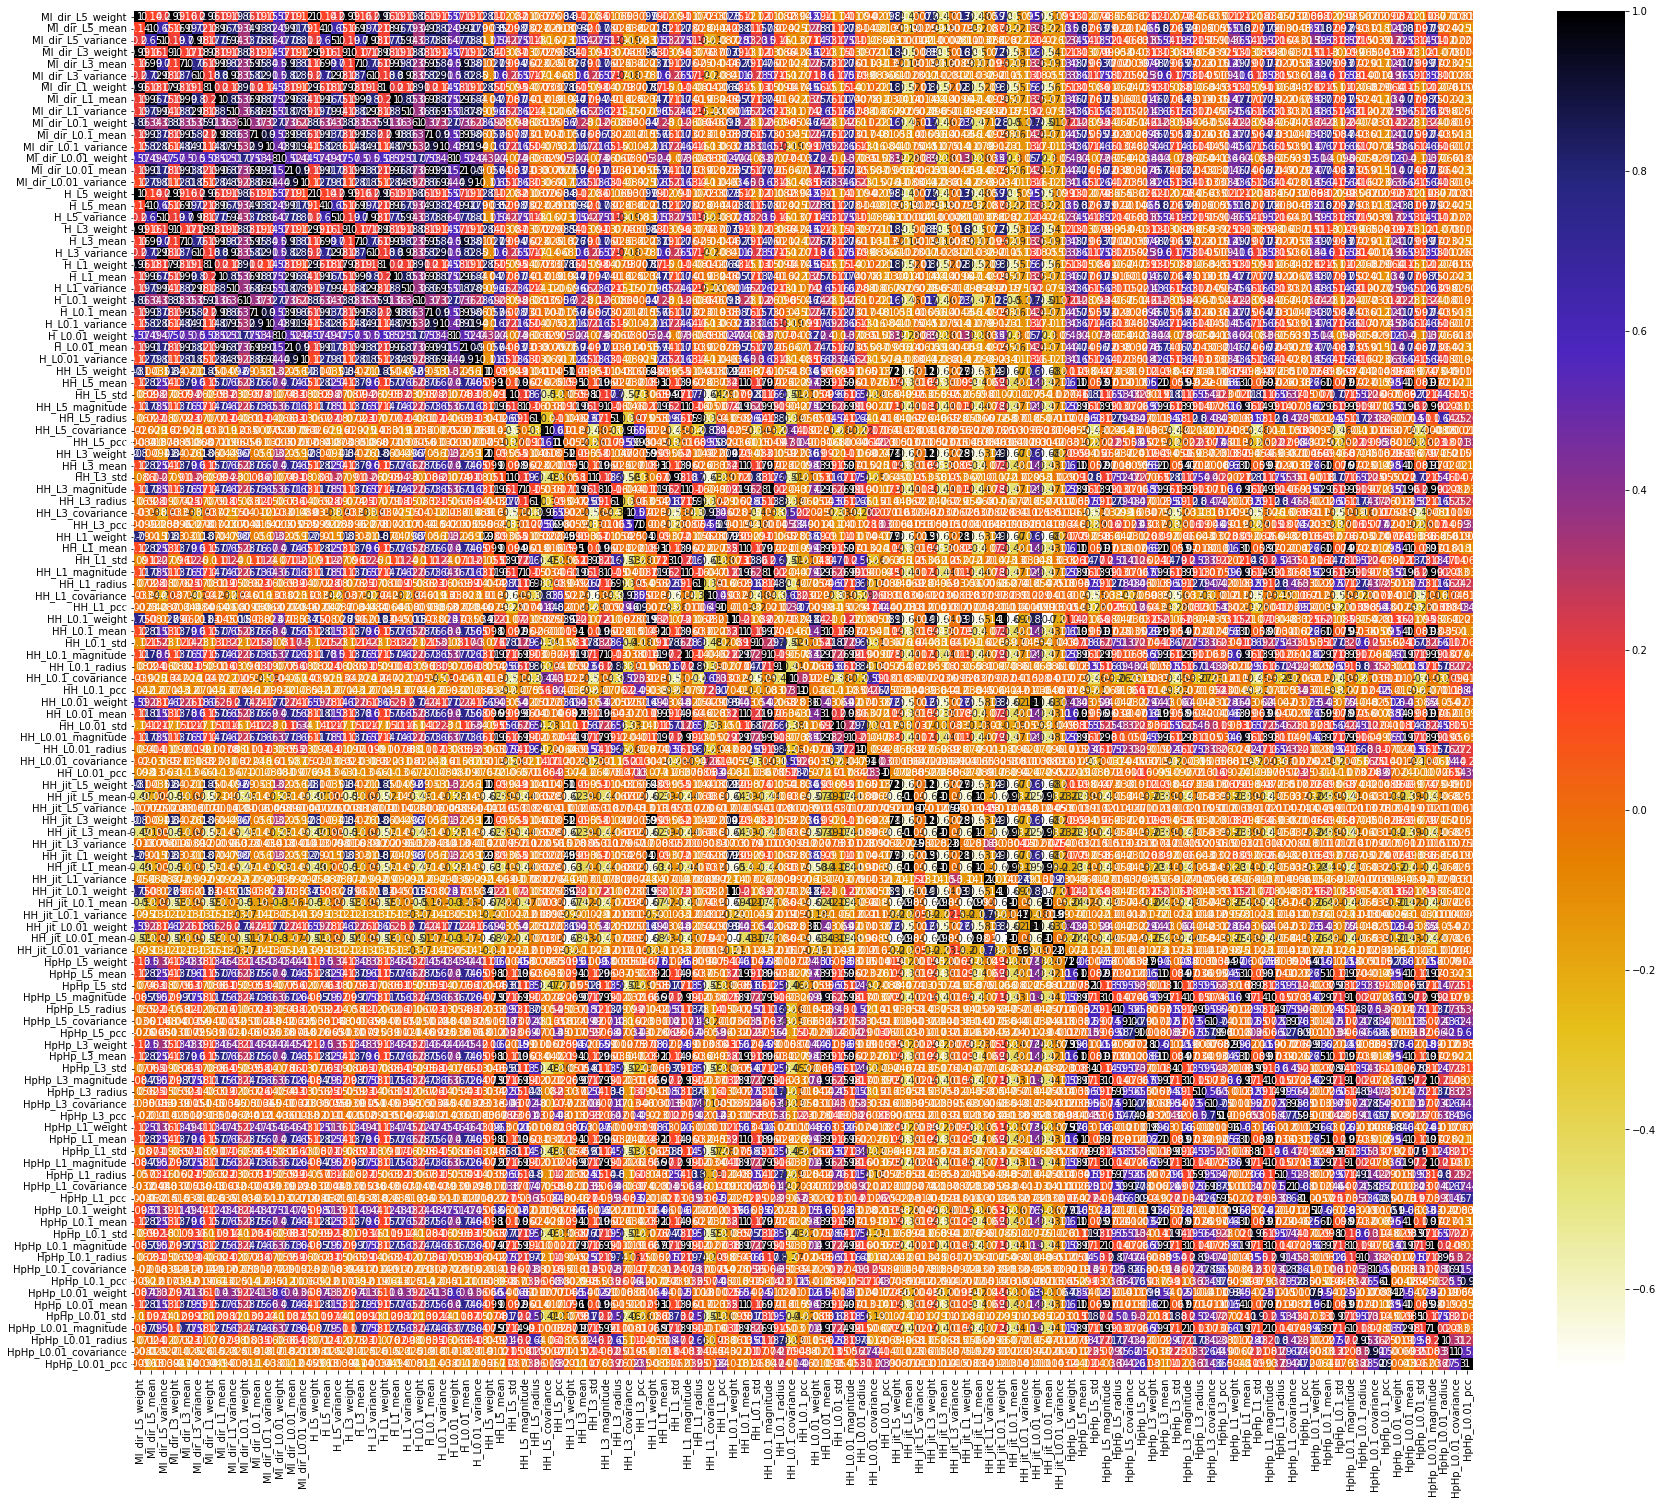

In [10]:
import seaborn as sns
plt.figure(figsize=(30,25))
cor = x_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

select highly correlated features

In [11]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [12]:
corr_features = correlation(x_train, 0.8)
len(set(corr_features))
print("correlated features: ", len(set(corr_features)))

correlated features:  95


In [13]:
print("correlated features are: ", corr_features )

correlated features are:  {'H_L5_weight', 'HH_L0.01_mean', 'HpHp_L1_magnitude', 'HpHp_L0.1_mean', 'HH_L0.01_weight', 'HpHp_L0.1_pcc', 'HpHp_L0.01_radius', 'HH_jit_L0.01_variance', 'MI_dir_L3_mean', 'HpHp_L0.1_weight', 'HH_jit_L0.01_weight', 'HpHp_L5_std', 'HH_L1_std', 'HH_L0.1_std', 'HH_L1_pcc', 'HpHp_L0.01_weight', 'HH_jit_L0.1_mean', 'HpHp_L3_magnitude', 'HH_jit_L3_mean', 'HH_L0.01_radius', 'HH_L0.01_magnitude', 'HpHp_L3_mean', 'MI_dir_L3_variance', 'HpHp_L5_magnitude', 'HpHp_L3_covariance', 'HpHp_L0.1_covariance', 'HH_L1_covariance', 'H_L1_mean', 'HH_L3_weight', 'HpHp_L3_weight', 'H_L0.1_mean', 'HH_L0.1_magnitude', 'H_L5_variance', 'MI_dir_L3_weight', 'HH_L0.01_std', 'HpHp_L1_weight', 'HpHp_L1_radius', 'HpHp_L0.01_mean', 'H_L0.01_weight', 'H_L0.01_mean', 'MI_dir_L0.01_variance', 'HH_jit_L3_variance', 'H_L0.1_weight', 'HH_jit_L3_weight', 'HH_L3_radius', 'HpHp_L1_covariance', 'H_L3_weight', 'MI_dir_L1_variance', 'H_L3_mean', 'HpHp_L0.1_std', 'H_L3_variance', 'MI_dir_L0.1_weight', 'HH_

In [14]:
x_train.shape

(569492, 115)

In [15]:
x_train_noncorr = x_train.drop(corr_features, axis=1)

In [16]:
x_train_noncorr.shape

(569492, 20)

In [17]:
x_test_noncorr = x_test.drop(corr_features, axis =1)

In [18]:
x_test_noncorr.shape

(244068, 20)

In [19]:
y_train.shape

(569492,)

In [20]:
x_train.shape, y_train.shape

((569492, 115), (569492,))

In [21]:
x_train_noncorr.shape, x_test_noncorr.shape

((569492, 20), (244068, 20))

In [ ]:
import datetime
start = datetime.datetime.now()
model_ncr = XGBClassifier()
model_ncr.fit(x_train_noncorr, y_train)
end = datetime.datetime.now()
print("Total execution time on 20 features: ", end-start)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred_ncr = model_ncr.predict(x_test_noncorr)

print("Accuracy score on 20 features: ", accuracy_score(y_test,y_pred_ncr)*100)
print("Confusion matrix:\n ", confusion_matrix(y_test,y_pred_ncr))

print("Corect prediction are: ",sum(y_test == y_pred_ncr))
print("Incorrect predictions are :", sum(y_test!= y_pred_ncr))

Accuracy score on 20 features:  54.44444444444444
Confusion matrix:
  [[27  0  0]
 [ 2 22  0]
 [ 0 39  0]]
Corect prediction are:  49
Incorrect predictions are : 41


In [ ]:
confusion_m =  pd.crosstab(y_test,model_ncr.predict(x_test_noncorr))

In [ ]:
print("Accuracy is: ",(np.diag(confusion_m).sum()/confusion_m.sum().sum())*100)

In [ ]:
fig = plt.figure(figsize=(10,5))

sn.heatmap(confusion_m,annot=True,cmap='Blues')